In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import exposure,transform
import os
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import LinearSVC,SVC
from sklearn.calibration import CalibratedClassifierCV
import random
from tqdm import tqdm
from joblib import load,dump

In [2]:
def image_pad(img,tobesize = (128,128)):
    old_image_height, old_image_width, channels = img.shape
    # create new image of desired size and color (blue) for padding
    new_image_height , new_image_width= tobesize
    color = (255,255,255)
    result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image

    result[y_center:y_center+old_image_height, x_center:x_center+old_image_width] = img

    return result

def find_percent_transparent(image):
    return 100 - np.average(image[:,:,3])*100/255

def random_square_background(dir_name,size = -1,N = 1,threshold_percent = 10,ret_alpha = True):
    l = []
    bglist = os.listdir(dir_name)
    count_fail = 0
    while len(l) < N:
        if count_fail > 20:
            threshold_percent += 10
            count_fail = 0
        image_name = np.random.choice(bglist)
        background = cv2.imread(f'{dir_name}\\{image_name}',cv2.IMREAD_UNCHANGED)
        if size == -1:
            size = np.random.randint(100,800)
        elif type(size) == tuple:
            if len(size) != 2:
                raise Exception('You can only use a tuple with two integers!')
            else:
                size = np.random.randint(size[0],size[1])


        if background.ndim == 2:
            height, width = background.shape
        else:
            height, width, nchannel = background.shape
        if height < size or width < size:
            size = min(height,width)
        x = np.random.randint(0,max(1,width-size+1))
        y = np.random.randint(0,max(1,height-size+1))

        patch = background[y:y+size,x:x+size]

        if find_percent_transparent(patch) < threshold_percent:
            if ret_alpha:
                l.append(patch)
            else:
                l.append(patch[:,:,0:3])
            count_fail = 0
        else:
            count_fail += 1

    if N == 1:
        return l[0]
    return l

def rotate_img(image,deg,size = None,borderValue = (255,255,255)):
    
    if size == None:
        height,width = image.shape[0:2]
    else:
        height,width = size
    M = cv2.getRotationMatrix2D((height//2,width//2),deg,1) 
    return cv2.warpAffine(image,M,(height,width),borderValue=borderValue) 

def visualize_hog(image, orientations = 8, pixels_per_cell=(32, 32) ,cells_per_block = (2, 2)):
    fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, visualize=True, channel_axis=-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Input image')
    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()
    print(len(fd))


def read_amongus(dir_path,patchsize = (96,72)):
    img = cv2.imread(dir_path,cv2.IMREAD_UNCHANGED)
    img2 = img[:,:,0:3]
    img2[img[:,:,3] < 128] = 255
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGRA2RGB)
    patchsize_xy = patchsize[::-1] #xy
    img3 = cv2.resize(img2,patchsize_xy)
    return img3

def extract_patches(img, N, patch_size, scale=1.0):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    patches = extract_patches_2d(img,extracted_patch_size,max_patches=N)
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

def paste_into_bg(imgbg,imgamogus):
    img = image_pad(imgamogus,imgbg.shape[0:2])
    b = (img == 255).all(axis = 2)
    imgbg[np.dstack((~b,~b,~b))] = img[np.dstack((~b,~b,~b))]
    return imgbg

def read_all_images(dir,name_list,with_alpha = False):
    l = []
    for name in name_list:
        if with_alpha:
            l.append(cv2.imread(f'{dir}//{name}',cv2.IMREAD_UNCHANGED))
        else:
            l.append(cv2.imread(f'{dir}//{name}'))
    return l

def horizontal_mirror(image):
    return image[:,::-1]

# Try with Dataset

In [4]:
pos_im_path = "../GenData/crewmate" # This is the path of our positive input dataset
# define the same for negatives
neg_im_path= "../GenData/bg"
walk_im_path= "../GenData/walking"
pos_im_listing0 = os.listdir(pos_im_path) # it will read all the files in the positive image path (so all the required images)
neg_im_listing0 = os.listdir(neg_im_path)
walk_im_listing0 = os.listdir(walk_im_path)
#num_pos_samples = size(pos_im_listing) # simply states the total no. of images
#num_neg_samples = size(neg_im_listing)
pos_im_listing = []
neg_im_listing = []

for name in pos_im_listing0:
    if name[-4:] not in ['.zip','.rar']:
        pos_im_listing.append(name)
for name in walk_im_listing0:
    if name[-4:] not in ['.zip','.rar']:
        pos_im_listing.append(name)
for name in neg_im_listing0:
    if name[-4:] not in ['.zip','.rar']:
        neg_im_listing.append(name)

print(f'No of Positive Images :{len(pos_im_listing)}')
print(f'No of Negative Images :{len(neg_im_listing)}')

print(pos_im_listing[0:5]) 
print(neg_im_listing[0:5])
patchsize_yx = (128,128)

orientations=8
pixels_per_cell=(16, 16)
cells_per_block=(2, 2)

No of Positive Images :29
No of Negative Images :17
['Black.png', 'Blue.png', 'Brown.png', 'Cyan.png', 'Green.png']
['canteen - Copy.jpg', 'canteen.jpg', 'The_Skeld_Admin.png', 'The_Skeld_Cafeteria.png', 'The_Skeld_Communications.png']


In [5]:
data0 = []
N0 = 25000
N = N0//len(neg_im_listing)
for path in tqdm(neg_im_listing,desc='Progress by picture'): #this loop enables reading the files in the neg_im_listing variable one by one
    #path = random.choice(neg_im_listing)
    image = cv2.imread(f'{neg_im_path}//{path}')
    image = cv2.cvtColor(image,cv2.COLOR_BGRA2RGB) 
    patches = extract_patches(image, N, patchsize_yx, scale=1.0)
    for patch in patches:
        fd = hog(patch, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False, channel_axis=-1)
        data0.append(fd)


Progress by picture: 100%|██████████| 15/15 [01:34<00:00,  6.28s/it]


In [6]:
data1= []
N1 = 15000
n = N1 // len(pos_im_listing)
bgs = read_all_images(neg_im_path,neg_im_listing)
for file in tqdm(pos_im_listing): #this loop enables reading the files in the pos_im_listing variable one by one
    img = read_amongus(f'{pos_im_path}\\{file}')
    
    bg = random.choice(bgs)

    bg_patches = extract_patches(bg, N, patchsize_yx, scale=1.0)
    for patch in bg_patches:
        deg = np.random.randint(-30,30)
        img_rotated = rotate_img(img,deg)
        if np.random.randint(2):
            img_rotated = horizontal_mirror(img_rotated)
        pos_im = paste_into_bg(patch,img_rotated)
        fd = hog(pos_im, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False, channel_axis=-1)
        data1.append(fd)

    # for i in range(8):
    #     for i in range(5):
    #         imgbg = cv2.imread(f'{neg_im_path}//{np.random.choice(neg_im_listing)}')
    #         imgbg2 = extract_patches(imgbg, 1, patchsize_yx, scale=1.0).reshape((128,128,3))
    #         img = read_amongus(f'{pos_im_path}\\Red.png')
    #         img = image_pad(img)
    #         b = (img == 255).all(axis = 2)
    #         imgbg2[np.dstack((~b,~b,~b))] = img[np.dstack((~b,~b,~b))]
    #         img = imgbg2
    #         fd = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
    #         data1.append(fd)
    #         #plt.imshow(img)
    #         #plt.show()
    #     img = cv2.warpAffine(img2,rotation_matrix,(256,256),borderValue=(255,255,255))

100%|██████████| 27/27 [03:36<00:00,  8.01s/it]


In [7]:
X = np.vstack((data1, data0))
y = np.hstack((np.ones(len(data1)), np.zeros(len(data0))))


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = np.random.randint(1, 100))
grid = GridSearchCV(SVC(kernel = 'linear',probability = True), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

1.0

In [9]:
model = grid.best_estimator_
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
dump(model, 'Model/model.joblib') 

In [10]:
def sliding_window(image, stepSize, windowSize,returnSize = patchsize_yx):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y1 in range(0, image.shape[1] - windowSize[1], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x1 in range(0, image.shape[0] - windowSize[0], stepSize):
            # yield the current window
            #yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])
            y2 = y1 + windowSize[0]
            x2 = x1 + windowSize[1]
            patch = image[y1: y2, x1: x2]
            if patch.shape[0:2] == windowSize:
                return_patch = cv2.resize(patch,returnSize)
                yield (x1, y1,x2, y2, return_patch)

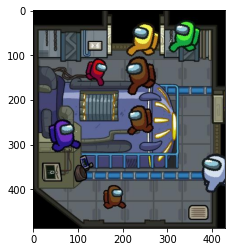

In [27]:
test_img = cv2.imread('Test Pic\\img12.jpg')
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()

In [43]:
sliding_window_sizes_percent = [22,25]
sws_array = np.array(sliding_window_sizes_percent)
imh,imw,nchannel = test_img.shape
short_side = min(imh,imw)
sliding_window_sizes = np.round(sws_array*short_side/100).astype(int)
step_size = np.ceil(sliding_window_sizes/8).astype(int)

In [44]:
patches = []
for i in range(len(sliding_window_sizes_percent)):
    tup = (sliding_window_sizes[i],sliding_window_sizes[i])
    patches += list(sliding_window(test_img,step_size[i],tup))

patches_hog = np.array([hog(patch, orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block, visualize=False, channel_axis=-1)\
     for _,_,_,_,patch in tqdm(patches)])

labels = model.predict(patches_hog)

100%|██████████| 1336/1336 [00:05<00:00, 233.66it/s]


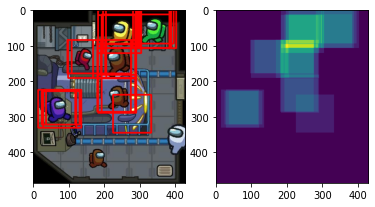

In [45]:
heatmap = np.zeros_like(test_img[:,:,0])
image = test_img.copy()
for i,patch in enumerate(patches):
    if labels[i] == 1:
        x1,y1,x2,y2,p = patch
        heatmap[y1:y2,x1:x2] += 1
        image = cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),4)
fig,ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(heatmap)
plt.show()

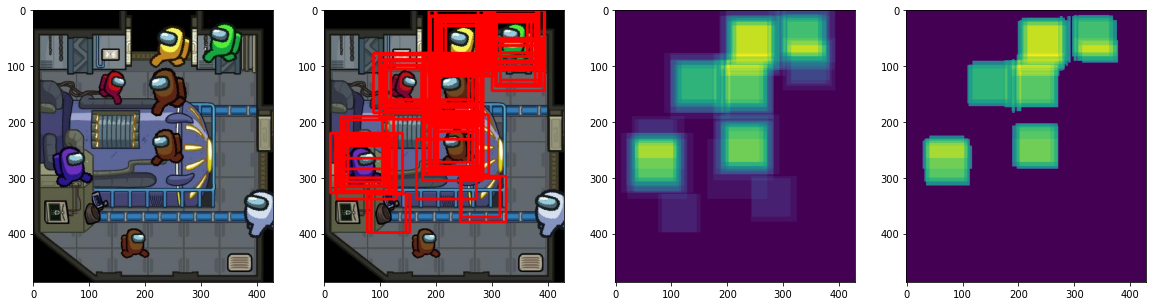

In [15]:
max_heat = np.max(heatmap)
ret,thresh1 = cv2.threshold(heatmap,max_heat*0.4,max_heat,cv2.THRESH_TOZERO)
fig,ax = plt.subplots(1,4,figsize = (20,5))
ax[0].imshow(test_img)
ax[1].imshow(image)
ax[2].imshow(heatmap)
ax[3].imshow(thresh1)
plt.show()
